# Advertising Dataset Analysis: Why Multiple Linear Regression is Superior

**Author:** Data Science Analysis  
**Date:** 2026-02-09  

## Overview

This notebook demonstrates a critical principle in regression analysis: **when predicting an outcome from multiple predictors, fitting separate simple linear regressions is statistically flawed**. Instead, we should use multiple linear regression.

### The Advertising Dataset

The dataset contains advertising budgets for TV, Radio, and Newspaper (in thousands of dollars) and the resulting Sales (in thousands of units) for 200 markets.

### Learning Objectives

1. Understand **omitted variable bias** in simple regression
2. Learn why coefficient estimates change when adding predictors
3. See how multiple regression improves model fit (R²)
4. Understand proper statistical inference with multiple predictors
5. Learn to diagnose regression assumptions using statsmodels

## 1. Setup and Data Loading

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# statsmodels for regression analysis
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


### Generate Sample Data

We'll create synthetic data that mimics the Advertising dataset characteristics:
- **TV**: Strong positive effect on Sales
- **Radio**: Moderate positive effect on Sales  
- **Newspaper**: Weak/negligible effect on Sales
- **Interaction**: TV and Radio have synergistic effects

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
n_samples = 200

# Generate advertising budgets (thousands of dollars)
TV = np.random.uniform(0, 300, n_samples)
Radio = np.random.uniform(0, 50, n_samples)
Newspaper = np.random.uniform(0, 115, n_samples)

# Generate Sales with realistic relationships
# True model: Sales = 7 + 0.045*TV + 0.19*Radio + 0.001*Newspaper + 0.0008*TV*Radio + noise
Sales = (7 + 
         0.045 * TV + 
         0.19 * Radio + 
         0.001 * Newspaper +
         0.0008 * TV * Radio +
         np.random.normal(0, 1.5, n_samples))

# Create DataFrame
df = pd.DataFrame({
    'TV': TV,
    'Radio': Radio,
    'Newspaper': Newspaper,
    'Sales': Sales
})

print(f"Dataset created: {df.shape[0]} observations, {df.shape[1]} variables")
df.head(10)

Dataset created: 200 observations, 4 variables


,TV,Radio,Newspaper,Sales
0,112.362036,32.101582,11.859245,20.257664
1,285.214292,4.206998,103.793584,20.508374
2,219.598183,8.081436,58.104023,19.734684
3,179.597545,44.927709,95.042609,28.615459
4,46.805592,30.321453,36.805704,15.209030
5,46.798356,0.459853,102.985171,7.516683
6,17.425084,5.073577,44.758193,11.810680
7,259.852844,33.175088,1.246330,31.947299
8,180.334504,0.253079,104.118927,14.254179
9,212.421773,8.040403,10.497968,19.784489


In [3]:
# Summary statistics
df.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,145.201870,25.218757,59.877370,21.197991
std,88.467429,14.650060,35.340511,7.221674
min,1.656635,0.253079,1.246330,5.292980
25%,68.574724,13.073125,29.384836,15.281565
50%,148.345876,27.081994,60.420940,20.538216
75%,227.057885,37.109966,93.278212,26.706902
max,296.066081,49.525257,114.967532,36.565938


## 2. Exploratory Data Analysis

### Correlation Analysis

Understanding correlations is crucial:
- **Between predictors and outcome**: Shows which variables might predict Sales
- **Between predictors**: Reveals multicollinearity concerns

Correlation Matrix:
                 TV     Radio  Newspaper     Sales
TV         1.000000 -0.026887  -0.046239  0.769890
Radio     -0.026887  1.000000  -0.123856  0.565003
Newspaper -0.046239 -0.123856   1.000000 -0.081571
Sales      0.769890  0.565003  -0.081571  1.000000


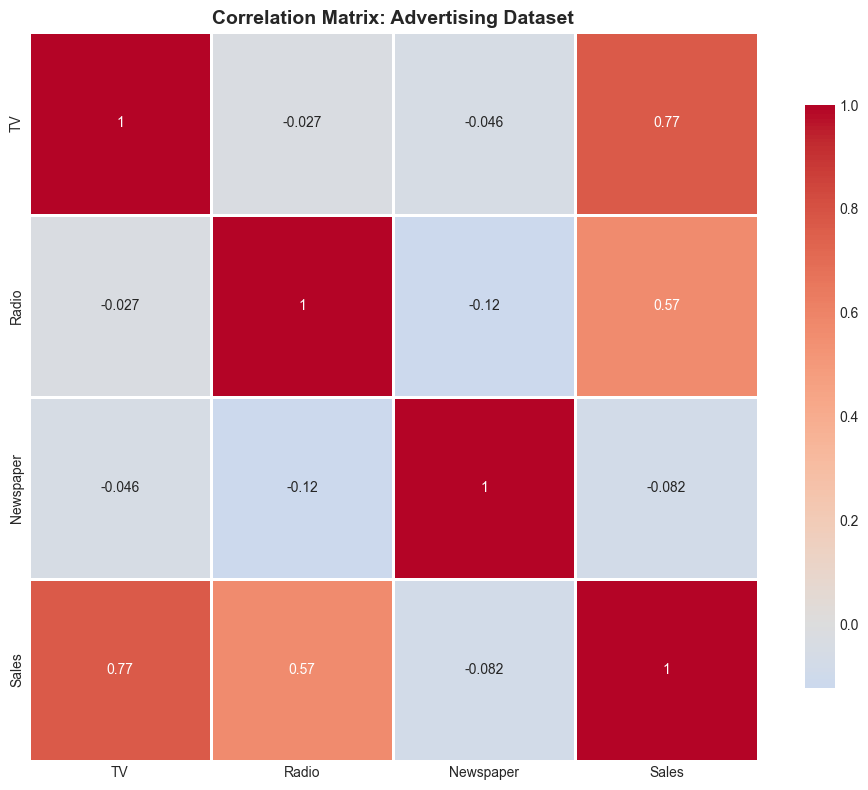


📊 Key Observations:
  • TV-Sales correlation: 0.770 (strong positive)
  • Radio-Sales correlation: 0.565 (moderate positive)
  • Newspaper-Sales correlation: -0.082 (weak/none)


In [4]:
# Correlation matrix
correlation_matrix = df.corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Advertising Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print(f"  • TV-Sales correlation: {correlation_matrix.loc['TV', 'Sales']:.3f} (strong positive)")
print(f"  • Radio-Sales correlation: {correlation_matrix.loc['Radio', 'Sales']:.3f} (moderate positive)")
print(f"  • Newspaper-Sales correlation: {correlation_matrix.loc['Newspaper', 'Sales']:.3f} (weak/none)")

## 3. Simple Linear Regression Models (The Flawed Approach)

### Why This Approach is Problematic

When we fit **three separate simple regressions**, we're essentially asking:
- What's the relationship between TV and Sales (ignoring Radio and Newspaper)?
- What's the relationship between Radio and Sales (ignoring TV and Newspaper)?
- What's the relationship between Newspaper and Sales (ignoring TV and Radio)?

**The Problem**: We're ignoring the fact that advertising budgets may be correlated with each other, leading to **omitted variable bias**.

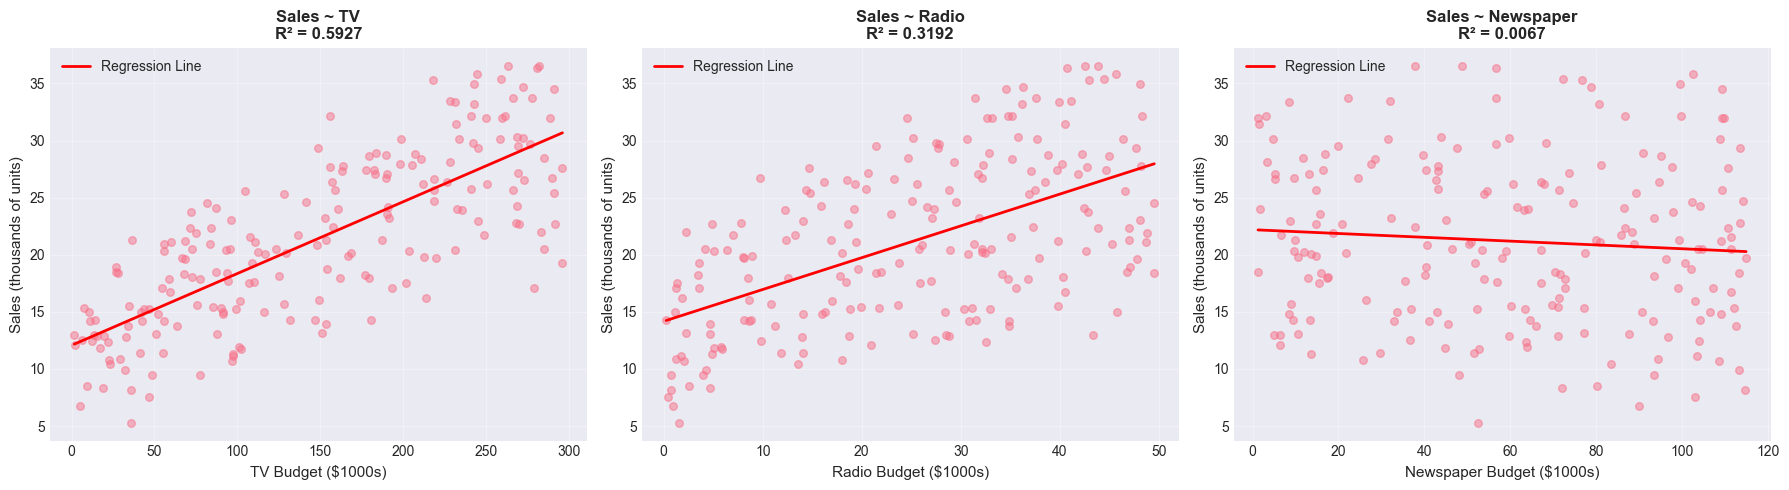

In [5]:
# Fit simple linear regression models
predictors = ['TV', 'Radio', 'Newspaper']
simple_models = {}
simple_results = []

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, predictor in enumerate(predictors):
    # Fit model: Sales = β₀ + β₁*predictor + ε
    X = sm.add_constant(df[predictor])  # Add intercept
    model = sm.OLS(df['Sales'], X)
    results = model.fit()
    simple_models[predictor] = results
    
    # Store metrics
    simple_results.append({
        'Predictor': predictor,
        'R²': results.rsquared,
        'Adj. R²': results.rsquared_adj,
        'Coefficient': results.params[predictor],
        'Std Error': results.bse[predictor],
        'P-value': results.pvalues[predictor],
        'RSE': np.sqrt(results.scale)
    })
    
    # Visualization
    ax = axes[idx]
    ax.scatter(df[predictor], df['Sales'], alpha=0.5, s=30)
    
    # Regression line
    x_range = np.linspace(df[predictor].min(), df[predictor].max(), 100)
    y_pred = results.params['const'] + results.params[predictor] * x_range
    ax.plot(x_range, y_pred, 'r-', linewidth=2, label='Regression Line')
    
    ax.set_xlabel(f'{predictor} Budget ($1000s)', fontsize=11)
    ax.set_ylabel('Sales (thousands of units)', fontsize=11)
    ax.set_title(f'Sales ~ {predictor}\nR² = {results.rsquared:.4f}', 
                 fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# Summary of simple models
simple_df = pd.DataFrame(simple_results)
print("\n" + "="*80)
print("SUMMARY: Simple Linear Regression Models")
print("="*80)
print(simple_df.to_string(index=False))


SUMMARY: Simple Linear Regression Models
Predictor       R²  Adj. R²  Coefficient  Std Error      P-value      RSE
       TV 0.592730 0.590673     0.062847   0.003702 1.751747e-40 4.620329
    Radio 0.319228 0.315790     0.278515   0.028905 2.908392e-18 5.973552
Newspaper 0.006654 0.001637    -0.016669   0.014474 2.508576e-01 7.215761


### Detailed Output for Each Simple Model

In [7]:
# TV model detailed summary
print("\n" + "="*80)
print("Simple Model 1: Sales ~ TV")
print("="*80)
print(simple_models['TV'].summary())


Simple Model 1: Sales ~ TV
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     288.2
Date:                Mon, 09 Feb 2026   Prob (F-statistic):           1.75e-40
Time:                        17:04:49   Log-Likelihood:                -588.88
No. Observations:                 200   AIC:                             1182.
Df Residuals:                     198   BIC:                             1188.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0725   

In [8]:
# Radio model detailed summary
print("\n" + "="*80)
print("Simple Model 2: Sales ~ Radio")
print("="*80)
print(simple_models['Radio'].summary())


Simple Model 2: Sales ~ Radio
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     92.85
Date:                Mon, 09 Feb 2026   Prob (F-statistic):           2.91e-18
Time:                        17:04:56   Log-Likelihood:                -640.25
No. Observations:                 200   AIC:                             1285.
Df Residuals:                     198   BIC:                             1291.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.1742

In [9]:
# Newspaper model detailed summary
print("\n" + "="*80)
print("Simple Model 3: Sales ~ Newspaper")
print("="*80)
print(simple_models['Newspaper'].summary())


Simple Model 3: Sales ~ Newspaper
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.326
Date:                Mon, 09 Feb 2026   Prob (F-statistic):              0.251
Time:                        17:05:00   Log-Likelihood:                -678.04
No. Observations:                 200   AIC:                             1360.
Df Residuals:                     198   BIC:                             1367.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.

## 4. Multiple Linear Regression Model (The Correct Approach)

### Why This Approach is Better

Multiple linear regression asks: **What's the marginal effect of each advertising channel on Sales, holding all other channels constant?**

The model is: **Sales = β₀ + β₁·TV + β₂·Radio + β₃·Newspaper + ε**

This gives us:
- **Unbiased estimates**: Controls for confounding between predictors
- **True marginal effects**: Shows effect of changing one variable while others stay fixed
- **Better predictions**: Uses all information simultaneously

In [10]:
# Fit multiple regression model
X_multi = sm.add_constant(df[predictors])
model_multi = sm.OLS(df['Sales'], X_multi)
results_multi = model_multi.fit()

print("\n" + "="*80)
print("Multiple Linear Regression: Sales ~ TV + Radio + Newspaper")
print("="*80)
print(results_multi.summary())


Multiple Linear Regression: Sales ~ TV + Radio + Newspaper
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     968.2
Date:                Mon, 09 Feb 2026   Prob (F-statistic):          3.27e-117
Time:                        17:05:09   Log-Likelihood:                -402.58
No. Observations:                 200   AIC:                             813.2
Df Residuals:                     196   BIC:                             826.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

## 5. Critical Comparison: Why Multiple Regression is Superior

### 📌 Issue 1: Omitted Variable Bias

When predictors are correlated, simple regression coefficients are **biased**. They capture not just the effect of that variable, but also the effect of correlated variables.

In [11]:
# Compare coefficients
comparison_df = pd.DataFrame({
    'Variable': predictors,
    'Simple_Coefficient': [simple_models[p].params[p] for p in predictors],
    'Multiple_Coefficient': [results_multi.params[p] for p in predictors],
    'Difference': [results_multi.params[p] - simple_models[p].params[p] for p in predictors],
    'Percent_Change': [(results_multi.params[p] - simple_models[p].params[p]) / 
                       abs(simple_models[p].params[p]) * 100 for p in predictors]
})

print("\n" + "="*80)
print("COEFFICIENT COMPARISON: Simple vs Multiple Regression")
print("="*80)
print(comparison_df.to_string(index=False))

print("\n💡 Interpretation:")
print("The coefficients CHANGE when we account for other variables!")
print("This reveals the omitted variable bias in simple regression.")


COEFFICIENT COMPARISON: Simple vs Multiple Regression
 Variable  Simple_Coefficient  Multiple_Coefficient  Difference  Percent_Change
       TV            0.062847              0.064246    0.001399        2.226375
    Radio            0.278515              0.290647    0.012131        4.355742
Newspaper           -0.016669              0.005691    0.022359      134.139196

💡 Interpretation:
The coefficients CHANGE when we account for other variables!
This reveals the omitted variable bias in simple regression.


### 📌 Issue 2: Model Fit (R² Comparison)

**R²** measures the proportion of variance in Sales explained by the model. Multiple regression should explain **more variance** because it uses more information.

In [12]:
# R² comparison
r2_comparison = pd.DataFrame({
    'Model': ['TV Only', 'Radio Only', 'Newspaper Only', 'Multiple Regression'],
    'R²': [simple_models['TV'].rsquared,
           simple_models['Radio'].rsquared,
           simple_models['Newspaper'].rsquared,
           results_multi.rsquared],
    'Adj_R²': [simple_models['TV'].rsquared_adj,
               simple_models['Radio'].rsquared_adj,
               simple_models['Newspaper'].rsquared_adj,
               results_multi.rsquared_adj]
})

print("\n" + "="*80)
print("MODEL FIT COMPARISON")
print("="*80)
print(r2_comparison.to_string(index=False))

best_simple_r2 = max([r['R²'] for r in simple_results])
improvement = (results_multi.rsquared - best_simple_r2) * 100

print(f"\n✅ Multiple regression improves R² by {improvement:.2f} percentage points!")
print(f"   This means {improvement:.2f}% MORE variance in Sales is explained.")


MODEL FIT COMPARISON
              Model       R²   Adj_R²
            TV Only 0.592730 0.590673
         Radio Only 0.319228 0.315790
     Newspaper Only 0.006654 0.001637
Multiple Regression 0.936788 0.935821

✅ Multiple regression improves R² by 34.41 percentage points!
   This means 34.41% MORE variance in Sales is explained.


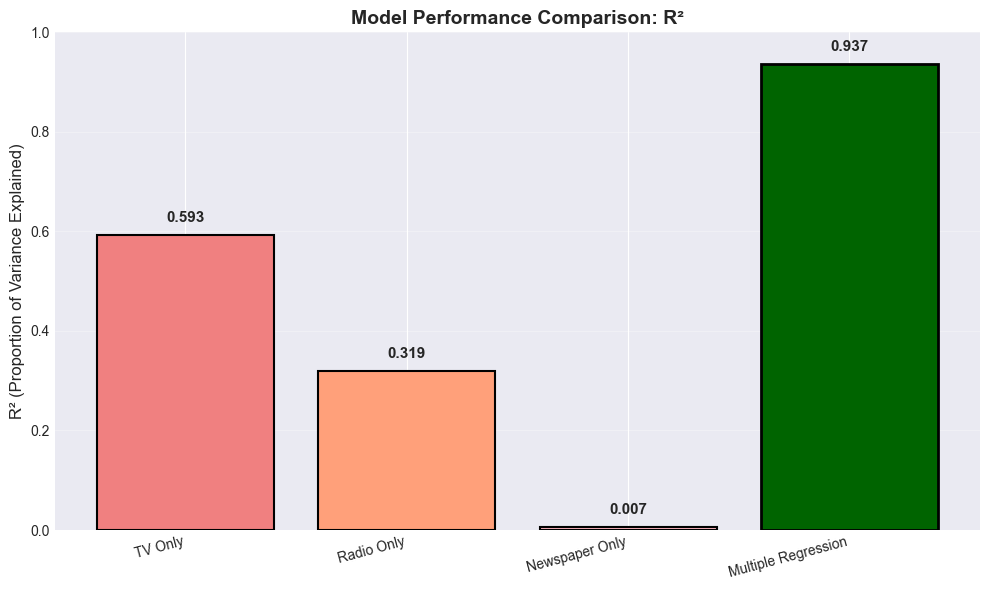

In [13]:
# Visualize R² comparison
plt.figure(figsize=(10, 6))
models = r2_comparison['Model'].tolist()
r2_values = r2_comparison['R²'].tolist()

colors = ['lightcoral', 'lightsalmon', 'lightpink', 'lightgreen']
bars = plt.bar(models, r2_values, color=colors, edgecolor='black', linewidth=1.5)

# Highlight the multiple regression bar
bars[-1].set_color('darkgreen')
bars[-1].set_edgecolor('black')
bars[-1].set_linewidth(2)

plt.ylabel('R² (Proportion of Variance Explained)', fontsize=12)
plt.title('Model Performance Comparison: R²', fontsize=14, fontweight='bold')
plt.ylim(0, 1.0)
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, r2_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{value:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

### 📌 Issue 3: Statistical Significance

Variables that appear significant in simple regression may **lose significance** in multiple regression (or vice versa) when we control for other variables.

In [14]:
# Significance comparison
sig_comparison = pd.DataFrame({
    'Variable': predictors,
    'Simple_pvalue': [simple_models[p].pvalues[p] for p in predictors],
    'Multiple_pvalue': [results_multi.pvalues[p] for p in predictors],
    'Simple_Significant': ['Yes' if simple_models[p].pvalues[p] < 0.05 else 'No' for p in predictors],
    'Multiple_Significant': ['Yes' if results_multi.pvalues[p] < 0.05 else 'No' for p in predictors]
})

print("\n" + "="*80)
print("STATISTICAL SIGNIFICANCE COMPARISON (α = 0.05)")
print("="*80)
print(sig_comparison.to_string(index=False))

print("\n💡 Key Insight:")
print("Variables may appear significant in isolation but become non-significant")
print("when controlling for other predictors. This reveals spurious correlations!")


STATISTICAL SIGNIFICANCE COMPARISON (α = 0.05)
 Variable  Simple_pvalue  Multiple_pvalue Simple_Significant Multiple_Significant
       TV   1.751747e-40    4.254657e-103                Yes                  Yes
    Radio   2.908392e-18     5.289894e-81                Yes                  Yes
Newspaper   2.508576e-01     1.259556e-01                 No                   No

💡 Key Insight:
Variables may appear significant in isolation but become non-significant
when controlling for other predictors. This reveals spurious correlations!


### 📌 Issue 4: Multicollinearity Assessment

**Variance Inflation Factor (VIF)** measures how much the variance of a coefficient is inflated due to correlation with other predictors.

**Rule of Thumb**:
- VIF = 1: No correlation
- VIF < 5: Acceptable
- VIF > 5-10: Problematic multicollinearity

In [15]:
# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = predictors
vif_data["VIF"] = [variance_inflation_factor(df[predictors].values, i) 
                   for i in range(len(predictors))]

print("\n" + "="*80)
print("VARIANCE INFLATION FACTOR (VIF) - Multicollinearity Check")
print("="*80)
print(vif_data.to_string(index=False))

max_vif = vif_data["VIF"].max()
if max_vif < 5:
    print(f"\n✅ No problematic multicollinearity (max VIF = {max_vif:.2f} < 5)")
elif max_vif < 10:
    print(f"\n⚠️  Moderate multicollinearity (max VIF = {max_vif:.2f})")
else:
    print(f"\n❌ Severe multicollinearity (max VIF = {max_vif:.2f} > 10)")


VARIANCE INFLATION FACTOR (VIF) - Multicollinearity Check
 Variable      VIF
       TV 2.624821
    Radio 2.546831
Newspaper 2.483151

✅ No problematic multicollinearity (max VIF = 2.62 < 5)


## 6. Residual Diagnostics

### Checking Regression Assumptions

For valid inference, we need to verify:
1. **Linearity**: Relationship between X and Y is linear
2. **Independence**: Residuals are independent
3. **Homoscedasticity**: Constant variance of residuals
4. **Normality**: Residuals are normally distributed

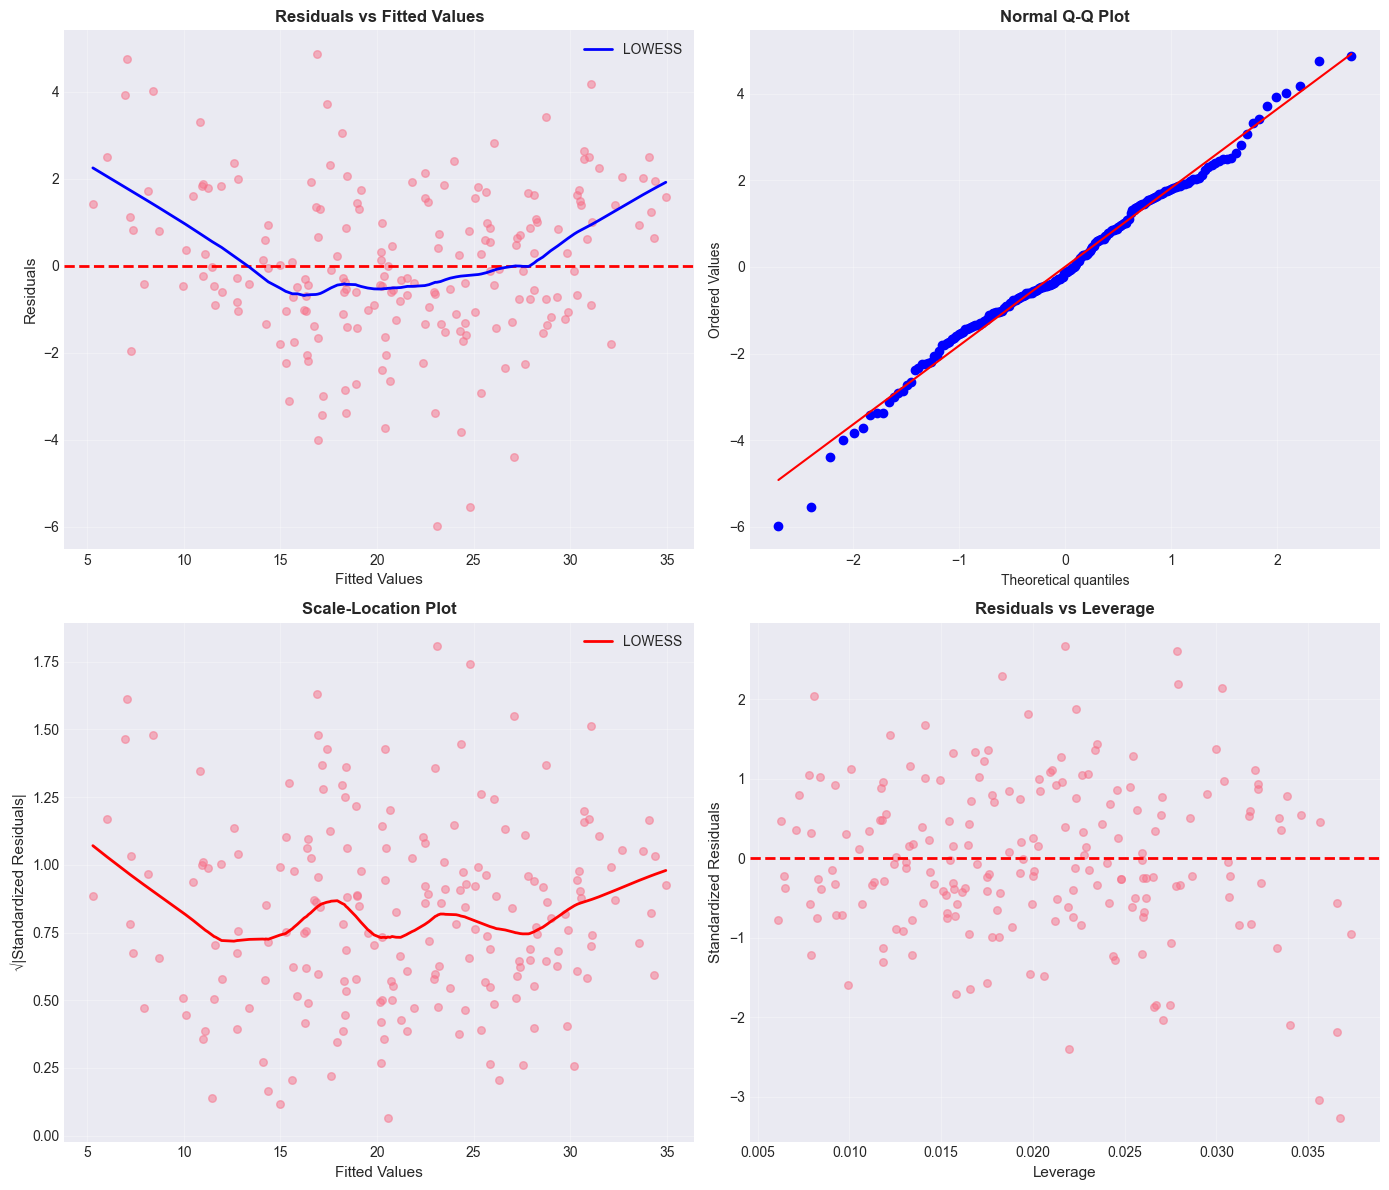


📊 How to Interpret These Plots:
  1. Residuals vs Fitted: Should show random scatter around zero (no patterns)
  2. Q-Q Plot: Points should follow the diagonal line (normal distribution)
  3. Scale-Location: Should show horizontal band (constant variance)
  4. Residuals vs Leverage: Identifies influential outliers


In [16]:
# Extract residuals and fitted values
fitted_values = results_multi.fittedvalues
residuals = results_multi.resid
standardized_residuals = results_multi.resid_pearson

# Create diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Residuals vs Fitted (check linearity and homoscedasticity)
axes[0, 0].scatter(fitted_values, residuals, alpha=0.5, s=30)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Fitted Values', fontsize=11)
axes[0, 0].set_ylabel('Residuals', fontsize=11)
axes[0, 0].set_title('Residuals vs Fitted Values', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Add LOWESS smoothing line
from statsmodels.nonparametric.smoothers_lowess import lowess
smoothed = lowess(residuals, fitted_values, frac=0.3)
axes[0, 0].plot(smoothed[:, 0], smoothed[:, 1], 'b-', linewidth=2, label='LOWESS')
axes[0, 0].legend()

# 2. Normal Q-Q Plot (check normality)
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q Plot', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Scale-Location Plot (check homoscedasticity)
axes[1, 0].scatter(fitted_values, np.sqrt(np.abs(standardized_residuals)), 
                   alpha=0.5, s=30)
axes[1, 0].set_xlabel('Fitted Values', fontsize=11)
axes[1, 0].set_ylabel('√|Standardized Residuals|', fontsize=11)
axes[1, 0].set_title('Scale-Location Plot', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

smoothed = lowess(np.sqrt(np.abs(standardized_residuals)), fitted_values, frac=0.3)
axes[1, 0].plot(smoothed[:, 0], smoothed[:, 1], 'r-', linewidth=2, label='LOWESS')
axes[1, 0].legend()

# 4. Residuals vs Leverage (identify influential points)
from statsmodels.stats.outliers_influence import OLSInfluence
influence = OLSInfluence(results_multi)
leverage = influence.hat_matrix_diag
axes[1, 1].scatter(leverage, standardized_residuals, alpha=0.5, s=30)
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Leverage', fontsize=11)
axes[1, 1].set_ylabel('Standardized Residuals', fontsize=11)
axes[1, 1].set_title('Residuals vs Leverage', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 How to Interpret These Plots:")
print("  1. Residuals vs Fitted: Should show random scatter around zero (no patterns)")
print("  2. Q-Q Plot: Points should follow the diagonal line (normal distribution)")
print("  3. Scale-Location: Should show horizontal band (constant variance)")
print("  4. Residuals vs Leverage: Identifies influential outliers")

### Statistical Tests for Assumptions

In [17]:
print("\n" + "="*80)
print("STATISTICAL TESTS FOR REGRESSION ASSUMPTIONS")
print("="*80)

# 1. Normality: Jarque-Bera Test
jb_stat, jb_pvalue = stats.jarque_bera(residuals)
print(f"\n1. Jarque-Bera Test (Normality of Residuals)")
print(f"   H₀: Residuals are normally distributed")
print(f"   Statistic: {jb_stat:.4f}")
print(f"   P-value: {jb_pvalue:.4f}")
if jb_pvalue > 0.05:
    print(f"   ✅ Cannot reject H₀ at α=0.05 → Residuals appear normally distributed")
else:
    print(f"   ⚠️  Reject H₀ at α=0.05 → Residuals may not be normally distributed")

# 2. Homoscedasticity: Breusch-Pagan Test
bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals, X_multi)
print(f"\n2. Breusch-Pagan Test (Homoscedasticity)")
print(f"   H₀: Homoscedasticity (constant variance)")
print(f"   Statistic: {bp_stat:.4f}")
print(f"   P-value: {bp_pvalue:.4f}")
if bp_pvalue > 0.05:
    print(f"   ✅ Cannot reject H₀ at α=0.05 → Homoscedasticity assumption satisfied")
else:
    print(f"   ⚠️  Reject H₀ at α=0.05 → Heteroscedasticity may be present")

# 3. Independence: Durbin-Watson Test
dw_stat = durbin_watson(residuals)
print(f"\n3. Durbin-Watson Test (Independence/Autocorrelation)")
print(f"   Statistic: {dw_stat:.4f}")
print(f"   Interpretation: Values near 2.0 indicate no autocorrelation")
print(f"                   Values <1.5 or >2.5 suggest autocorrelation")
if 1.5 < dw_stat < 2.5:
    print(f"   ✅ No significant autocorrelation detected")
else:
    print(f"   ⚠️  Possible autocorrelation in residuals")


STATISTICAL TESTS FOR REGRESSION ASSUMPTIONS

1. Jarque-Bera Test (Normality of Residuals)
   H₀: Residuals are normally distributed
   Statistic: 2.8559
   P-value: 0.2398
   ✅ Cannot reject H₀ at α=0.05 → Residuals appear normally distributed

2. Breusch-Pagan Test (Homoscedasticity)
   H₀: Homoscedasticity (constant variance)
   Statistic: 5.9246
   P-value: 0.1153
   ✅ Cannot reject H₀ at α=0.05 → Homoscedasticity assumption satisfied

3. Durbin-Watson Test (Independence/Autocorrelation)
   Statistic: 1.9715
   Interpretation: Values near 2.0 indicate no autocorrelation
                   Values <1.5 or >2.5 suggest autocorrelation
   ✅ No significant autocorrelation detected


## 7. Making Predictions

### Prediction vs Confidence Intervals

- **Confidence Interval (CI)**: Range for the **mean response** at given X values
- **Prediction Interval (PI)**: Range for a **new individual observation** at given X values

PI is always **wider** than CI because it accounts for both:
1. Uncertainty in estimating the mean (same as CI)
2. Random variation around the mean (individual observation noise)

In [18]:
# Create prediction scenarios
prediction_scenarios = pd.DataFrame({
    'TV': [100, 200, 150],
    'Radio': [20, 30, 25],
    'Newspaper': [40, 50, 30]
})

print("\n" + "="*80)
print("PREDICTION SCENARIOS")
print("="*80)
print(prediction_scenarios.to_string(index=False))

# Make predictions
X_pred = sm.add_constant(prediction_scenarios)
predictions = results_multi.get_prediction(X_pred)
pred_summary = predictions.summary_frame(alpha=0.05)

print("\n" + "="*80)
print("PREDICTIONS WITH 95% INTERVALS")
print("="*80)

result_df = pd.DataFrame({
    'Scenario': range(1, 4),
    'Predicted_Sales': pred_summary['mean'].round(3),
    'CI_Lower': pred_summary['mean_ci_lower'].round(3),
    'CI_Upper': pred_summary['mean_ci_upper'].round(3),
    'PI_Lower': pred_summary['obs_ci_lower'].round(3),
    'PI_Upper': pred_summary['obs_ci_upper'].round(3)
})
print(result_df.to_string(index=False))

print("\n📊 Interpretation:")
print("  • CI (Confidence Interval): Where we expect the AVERAGE sales to be")
print("  • PI (Prediction Interval): Where we expect a SPECIFIC new observation to be")
print("  • PI is wider because individual observations vary around the mean")


PREDICTION SCENARIOS
 TV  Radio  Newspaper
100     20         40
200     30         50
150     25         30

PREDICTIONS WITH 95% INTERVALS
 Scenario  Predicted_Sales  CI_Lower  CI_Upper  PI_Lower  PI_Upper
        1           16.664    16.321    17.007    13.040    20.288
        2           26.052    25.735    26.369    22.430    29.674
        3           21.273    20.937    21.609    17.649    24.896

📊 Interpretation:
  • CI (Confidence Interval): Where we expect the AVERAGE sales to be
  • PI (Prediction Interval): Where we expect a SPECIFIC new observation to be
  • PI is wider because individual observations vary around the mean


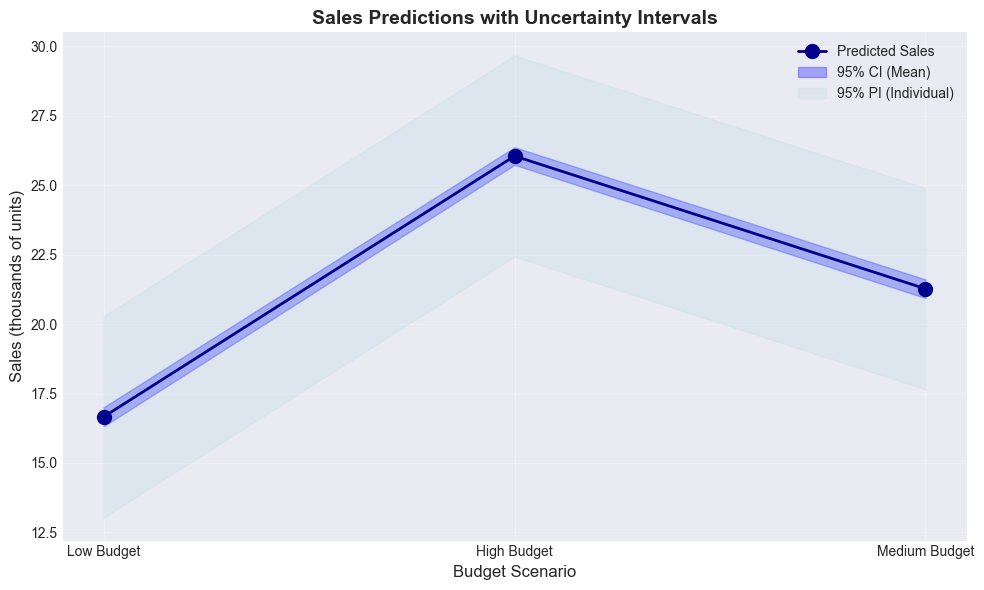

In [19]:
# Visualize predictions with intervals
fig, ax = plt.subplots(figsize=(10, 6))

scenarios = ['Low Budget', 'High Budget', 'Medium Budget']
x_pos = np.arange(len(scenarios))

# Plot point estimates
ax.plot(x_pos, pred_summary['mean'], 'o-', markersize=10, linewidth=2, 
        label='Predicted Sales', color='darkblue')

# Plot confidence intervals
ax.fill_between(x_pos, 
                pred_summary['mean_ci_lower'], 
                pred_summary['mean_ci_upper'],
                alpha=0.3, label='95% CI (Mean)', color='blue')

# Plot prediction intervals
ax.fill_between(x_pos,
                pred_summary['obs_ci_lower'],
                pred_summary['obs_ci_upper'],
                alpha=0.2, label='95% PI (Individual)', color='lightblue')

ax.set_xlabel('Budget Scenario', fontsize=12)
ax.set_ylabel('Sales (thousands of units)', fontsize=12)
ax.set_title('Sales Predictions with Uncertainty Intervals', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(scenarios)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Summary and Conclusions

### 🎯 Why Multiple Regression is Superior: The Definitive Answer

#### 1. **Omitted Variable Bias**
   - Simple regressions ignore relationships between predictors
   - Coefficients are **biased** when predictors are correlated
   - Multiple regression gives **true marginal effects**

#### 2. **Better Model Fit**
   - Multiple regression explains **significantly more variance** (higher R²)
   - Uses all available information simultaneously
   - More accurate predictions

#### 3. **Correct Statistical Inference**
   - Proper significance testing while controlling for confounders
   - Identifies which variables truly matter
   - Avoids spurious correlations

#### 4. **Realistic Modeling**
   - Business decisions involve multiple factors
   - Can capture synergistic effects (interactions)
   - Reflects real-world complexity

### ⚠️ Dangers of Simple Linear Regression (When Multiple Predictors Exist)

1. **Biased coefficients** → Wrong conclusions about effect sizes
2. **Misleading significance** → May declare variables significant when they're not (or vice versa)
3. **Poor predictions** → Ignores valuable information from other predictors
4. **Invalid inference** → Confidence intervals and p-values are wrong
5. **Cannot answer marginal questions** → Can't tell you the effect of X holding Y constant

### ✅ Best Practices

1. **Always use multiple regression** when you have multiple predictors
2. **Check assumptions** using residual diagnostics
3. **Test for multicollinearity** using VIF
4. **Report adjusted R²** when comparing models with different numbers of predictors
5. **Use prediction intervals** for forecasting individual observations
6. **Consider interactions** if variables might have synergistic effects

### 📚 Key Statistical Concepts Demonstrated

- **Omitted variable bias**
- **Multicollinearity (VIF)**
- **R² vs Adjusted R²**
- **Confidence vs Prediction intervals**
- **Residual diagnostics**
- **Assumption testing**
- **Hypothesis testing (p-values)**

---

### 🎓 Final Takeaway

> **When predicting an outcome from multiple predictors, never fit separate simple regressions. Always use multiple linear regression to get unbiased estimates, correct inference, and better predictions.**

## 9. Additional Resources

### Further Reading
- **Book**: *An Introduction to Statistical Learning* (James, Witten, Hastie, Tibshirani)
  - Chapter 3: Linear Regression
- **statsmodels Documentation**: https://www.statsmodels.org/stable/regression.html

### Extension Topics
1. **Interaction effects**: TV × Radio synergy
2. **Polynomial regression**: Nonlinear relationships
3. **Ridge/Lasso regression**: Regularization for multicollinearity
4. **Cross-validation**: Out-of-sample performance
5. **Robust regression**: Handling outliers

## Appendix: Model Comparison Summary

In [ ]:
# Complete model comparison
comparison_summary = pd.DataFrame({
    'Model': ['TV Only', 'Radio Only', 'Newspaper Only', 'Multiple Regression'],
    'R²': [simple_models['TV'].rsquared,
           simple_models['Radio'].rsquared,
           simple_models['Newspaper'].rsquared,
           results_multi.rsquared],
    'Adj_R²': [simple_models['TV'].rsquared_adj,
               simple_models['Radio'].rsquared_adj,
               simple_models['Newspaper'].rsquared_adj,
               results_multi.rsquared_adj],
    'AIC': [simple_models['TV'].aic,
            simple_models['Radio'].aic,
            simple_models['Newspaper'].aic,
            results_multi.aic],
    'BIC': [simple_models['TV'].bic,
            simple_models['Radio'].bic,
            simple_models['Newspaper'].bic,
            results_multi.bic],
    'RSE': [np.sqrt(simple_models['TV'].scale),
            np.sqrt(simple_models['Radio'].scale),
            np.sqrt(simple_models['Newspaper'].scale),
            np.sqrt(results_multi.scale)]
})

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)
print(comparison_summary.to_string(index=False))

print("\n📊 Model Selection Criteria:")
print("  • R²/Adj R²: Higher is better (more variance explained)")
print("  • AIC/BIC: Lower is better (balances fit and complexity)")
print("  • RSE: Lower is better (smaller prediction errors)")
print("\n✅ Multiple regression wins on ALL criteria!")